# MODELO SEIR - Covid-19 Bogotá

In [1]:
# =================================== LIBRERIAS =========================================
# Importando librerias requeridas.

import pandas as pd
import patchsim as sim
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import nlopt
import time

In [2]:
# ================================ARCHIVO CONFIG.TXT ============================================

# Hay dos configuraciones de prueba básicas (determinista y estocástica) en la carpeta de
# prueba. La configuraciòn determinista tiene el siguiente aspecto:

# CARACTERISTICAS:
#
#   ARCHIVOS:
#     PatchFile: Pop.txt    --->   Definido posteriormente
#     NetworkFile: Net.txt  --->   Definido posteriormente
#     SeedFile: Seeds.txt   --->   Definido posteriormente
#     ParamFile: Param.txt  --->   Definido posteriormente
#     NetworkType: 
#        • PatchSim actualmente acepta tres tipos de red diferentes: 
#          Dependiendo del NetworkType, el <time_index> en NetworkFile toma los siguientes valores.
#             - Estático: <time_index> es siempre 0.
#             - Mensual: <time_index> toma todos los valores de [0, 11] --> (0 = enero).
#             - Semanal: <time_index> toma todos los valores de [0, 52] --> (0 = 1 al 7 de enero)
#   PARAMETROS
#     Los parámetros de enfermedad ExposureRate, InfectionRate y RecoveryRate generalmente se 
#     enumeran en el archivo de configuración. 
#   CICLO DE TIEMPO
#     El ciclo simulado es desde: StartDate = 1 (01/01/2020), con una duracion de 500 dias.

def write_config(beta, symprob, file="files1/cfg.txt"):    
    f = open(file, "w")
    
    f.write("PatchFile=files1/pop.txt\n")
    f.write("NetworkFile=files1/net.txt\n")
    f.write("SeedFile=files1/seeds.txt\n")
    f.write("ParamFile=files1/param.txt\n\n")
    f.write("NetworkType=Weekly\n")
 
    f.write("ExposureRate2="+str(beta)+"\n")
    f.write("InfectionRate=0.2173\n")
    f.write("RecoveryRate=0.47\n")
    f.write("SymptomaticProbability="+str(symprob)+"\n\n")
    
    f.write("StartDate=1\n")
    f.write("Duration=500\n\n")

    f.write("Model=Mobility\n")
    f.write("LoadState=False\n")   # La matriz de estados SEIR es generado por el modelo.
    f.write("SaveState=False\n\n") # No se necesita la matriz de estado SEIR completa,
                                   # solo los new_inf (Los nuevos infectados)
    f.write("OutputFile=files1/resultados.out\n")  # Los resultados se guardan en este archivo.
    f.write("OutputFormat=Whole\n")   # Los nuevos infectados son numeros enteros.
    f.write("LogFile=files1/proceso.log\n")  # El proceso es guardado en un archivo.
    f.close()

In [3]:
# ================================ARCHIVO POP.TXT =====================================

# Contiene los tamaños de la población de cada localidad en el siguiente formato para
# cada línea: <localidad_id> <tamaño_población>

def write_pop(localidades, file="files1/pop.txt"):
    df = pd.DataFrame( {"id_localidades":localidades["local_id"].values, 
                             "poblacion":localidades[ "PopCDR" ].values})
    df.to_csv(file, header = False, index = False, sep=' ')
    print("Hay {:,.0f} personas en las 19 localidades.".format(df["poblacion"].sum()))

In [4]:
# ================================ARCHIVO NET.TXT =====================================

# NetworkFile Contiene la matriz de viajes en el siguiente formato para cada línea:
# <localidad_id_i> <localidad_id_j> <time_index> <Theta_i,j> donde:
#      <loc_id_i> y <loc_id_j> son el id de la localidad i, y el id de la localidad j.
#      <time_index> lo hará tomar valores diferentes según el tipo de red (NetworkType).
#      <Theta_i,j> La cantidad de personas que viajan de la localidad i a la j.

def write_net(redes, ratios=pd.DataFrame(), file="files1/net.txt",
             disminuye_movilidad_60=False):    
    
    nxn = len(redes)  #19x19
    dias = np.zeros(nxn, dtype=int) # NetworkType = Estable
    hbw = redes["hbw"].values
    
    # Movilidad tiempo 0 -- Normalizando matriz.
    W = hbw.reshape(-1,19) # Matriz 19x19 Viaje localidad i a j.
    for i in range(19):  
        total_i = np.sum(W[i,:]) # Total en localidad i
        W[i,:] = W[i,:]/total_i
    hbw=W.reshape(-1)
    K = 1  # Identificador Estable
    
    # Vector para disminuir movilidad al 60%
    if disminuye_movilidad_60:
        ratio = np.ones((53, 19)) * 0.60
        K=53  # Identificador Semanal
    
    # Vector para disminuir movilidad segun radio.
    if ratios.empty == False:
        ratio = np.ones((53, 19))
        for index, row in ratios.iterrows(): 
            ratio[int(row.week)-1, int(row.loc_id)-1]=row.ratio   
        K=53  # Identificador Semanal
        
    if K == 53:  
        for k in range(1,53):  
            W1 = np.zeros((19,19))
            for i in range(19):
                W1[i,:] = W[i,:]*ratio[k,i]
                W1[i,i] = 0
                W1[i,i] = 1 - W1[i,:].sum()
            W = W1.copy()
            hbw = np.append(hbw, W1.reshape(-1))
            dias = np.append(dias, np.zeros(nxn, dtype=int)+k)
    
    #-----------------------------------------------------------------------------------------
    df = pd.DataFrame( {"origen":list(redes["o_loc"].values)*K, 
                        "destino":list(redes["d_loc"].values)*K, 
                        "semana":dias,
                        "hbw":hbw})
    df.to_csv(file, header = False, index = False, sep=' ')

In [5]:
# ================================ARCHIVO PARAM.TXT =====================================

#  Parámetros espacio-temporales: 
#  Si los usuarios desean utilizar valores heterogeneos de ExposureRate (beta) para 
#  localidades específicas, o hacer que varíe con el tiempo, entonces se puede incluir un
#  Atributo ParamFile, que apunta a un archivo.

def write_param(ratios, file="files1/param.txt"):

    # Matriz dias x localidad, cada item contiene radio de disminucion
    ratio = np.ones((53*7, 19))
    for index, row in ratios.iterrows(): 
        i, j = int(row.week)*7, int(row.loc_id)-1
        ratio[i:i+7,j] = row.ratio 

    df = pd.DataFrame(ratio).T 
    df.insert(0, "id", np.arange(19)+1, True)
    df.to_csv(file, header = False, index = False, sep=' ')

In [6]:
# =====================================ARCHIVO SEED.TXT ========================================

# SeedFile Contiene el cronograma de semillas (obligatorio) en el siguiente formato para cada 
# línea: <day> <localidad_id> <seed_cases>

def write_seed(Casos, file="files1/seeds.txt"):

    # Renombrando columnas
    casos = Casos.rename(columns={"LOCALIDAD_ASIS": 'Localidad',
                                  "FECHA_DE_INICIO_DE_SINTOMAS":'fecha'})
                                  #"FECHA_DIAGNOSTICO":'fecha'})
        
    # Convirtiendo en formato fecha de pandas
    casos["fecha"] = pd.to_datetime(casos["fecha"], format="%d/%m/%Y")  # to DateTime
    print("Dia 1 del inicio de sintomas:", casos["fecha"].min())

    # Calculando el tiempo transcurrido en dias
    dia1 = pd.to_datetime("01/01/2020", format="%d/%m/%Y")
    tiempo = casos["fecha"] - dia1 # Tiempo transcurrido
    casos['dia'] = tiempo.dt.days 
    casos.dropna(subset=['dia'], inplace=True)
    casos.dia = casos['dia'].apply(np.int)

    # Uniendo base de datos localidades y número de casos
    datos = pd.merge(casos, localidades, on='Localidad')  # Uniendo datos by id: "localidades".

    #  Aplicando función gamma (5)
    datos["dia"] = datos["dia"].apply(lambda x: x-int(np.random.gamma(5)))

    # Encontrando cantidad de casos por dia y localidad
    Ncasos = datos.groupby(['dia', 'local_id']).size().reset_index(name='n_casos_real') 

    #------------------------------------------------------------------------------------------------------------
    #  Generando archivo Semillas: Cantidad de infectados en los primeros 60 dias para cada localidad.
    df = Ncasos[Ncasos["dia"]<=70]
    df.reset_index(drop=True, inplace=True)
    df.to_csv(file, header = False, index = False, sep=' ')
    print("Cantidad de semillas iniciales:", len(df))
    return Ncasos

In [7]:
# =========================================== GRAFICAR ===============================================================
def graficar(casos_real, casos_sim, symprob, fechas=False, individual=False):
    cmap = plt.get_cmap('tab20')
    colors = [cmap(i) for i in np.linspace(0, 1, 19)]
    # Graficos
    if individual:
        fig, ax = plt.subplots(5,4,figsize=(15,13),dpi=100)
        ax = ax.reshape(-1)
    else:
        fig, [ax1,ax2] = plt.subplots(1,2,figsize=(12,4),dpi=120)
    for i in np.arange(19)+1:
        #-------------------------------------------------------------------
        # Casos reales
        loc = casos_real[casos_real["local_id"]==i] # Localidad i
        casos = loc["n_casos_real"].values
        tiempo = loc["dia"].values
        if individual:
            ax[i-1].plot(tiempo, casos, label="Reales", color=colors[-(i-1)])
        else:
            ax1.plot(tiempo, casos, label="Reales", color=colors[-(i-1)])
        #--------------------------------------------------------------------
        # Casos simulaciones
        infectados = casos_sim[casos_sim.index==str(i)].values[0]
        t = np.arange(0, len(infectados))
        if individual:
            ax[i-1].plot(t, symprob*infectados, lw=3, color="red")
        else:
            ax2.plot(t, symprob*infectados, lw=3, color=colors[-(i-1)],
                     label=str(localidades["Localidad"][i-1]) + " - Loc"+str(i))
        #---------------------------------------------------------------------
        # Propiedades gráficas
        if individual:
            ax[i-1].legend()
            ax[i-1].set_title(str(localidades["Localidad"][i-1]) + " - Loc"+str(i), fontsize=11)
            ax[i-1].set_ylabel("número de infectados", fontsize=11)
            ax[i-1].set_xlabel("dias")
            ax[i-1].set_xlim(0,500)
            ax[i-1].tick_params(axis='x', labelsize=11)
            ax[i-1].tick_params(axis='y', labelsize=11)
            ax[i-1].grid()
            ax[i-1].set_ylim(0,600)
        else: 
            ax2.legend(loc="right", bbox_to_anchor=(1.5,0.5), fontsize=8.3)
            ax1.set_title("Casos de Covid 19 en Bogotá - Reales")
            ax2.set_title("Casos de Covid 19 en Bogotá - Simulados")
            ax1.set_ylabel("número de infectados")
            ax2.set_ylabel("número de infectados")
            ax1.set_xticks(np.linspace(0,500,11))
            ax2.set_xticks(np.linspace(0,500,11))
            ax1.set_xlabel("dias")
            ax2.set_xlabel("dias")
            ax1.set_xlim(0,500)
            ax1.grid()
            ax2.grid()
    if fechas:
        dia1 = pd.to_datetime("01/01/2020", format="%d/%m/%Y")
        fechas = Ncasos["dia"].apply(lambda x: (dia1+dt.timedelta(days=x)).strftime("%d/%m/%Y"))
        dias = lambda ax: [(dia1+dt.timedelta(days=i)).strftime("%d/%b/%Y") for i in ax.get_xticks()]
        ax2.set_xticklabels(dias(ax2), rotation=60)
        ax1.set_xticklabels(dias(ax1), rotation=60)
    if individual:
        ax[-1].axis("off")
        fig.tight_layout()
        return ax
    else:
        return ax1, ax2

### ARCHIVOS INGRESADOS:

In [8]:
# Leyendo archivos
localidades = pd.read_csv("files/info_local_2020.csv")
conexiones = redes = pd.read_csv("files/cdr_od_loc.csv")
ratios = pd.read_csv("files/agregados_localidad.csv")
Semillas = pd.read_csv("files/osb_enftransm-covid-19_17042021.csv", 
                       nrows=732872, encoding='latin-1', delimiter=";")

# Escribiendo archivos
write_pop(localidades)
write_net(conexiones, ratios)
write_param(ratios)
casos_reales = write_seed(Semillas)

Hay 5,549,758 personas en las 19 localidades.
Dia 1 del inicio de sintomas: 2020-02-26 00:00:00
Cantidad de semillas iniciales: 95


### EJECUTANDO FUNCIÓN PATCHSIM

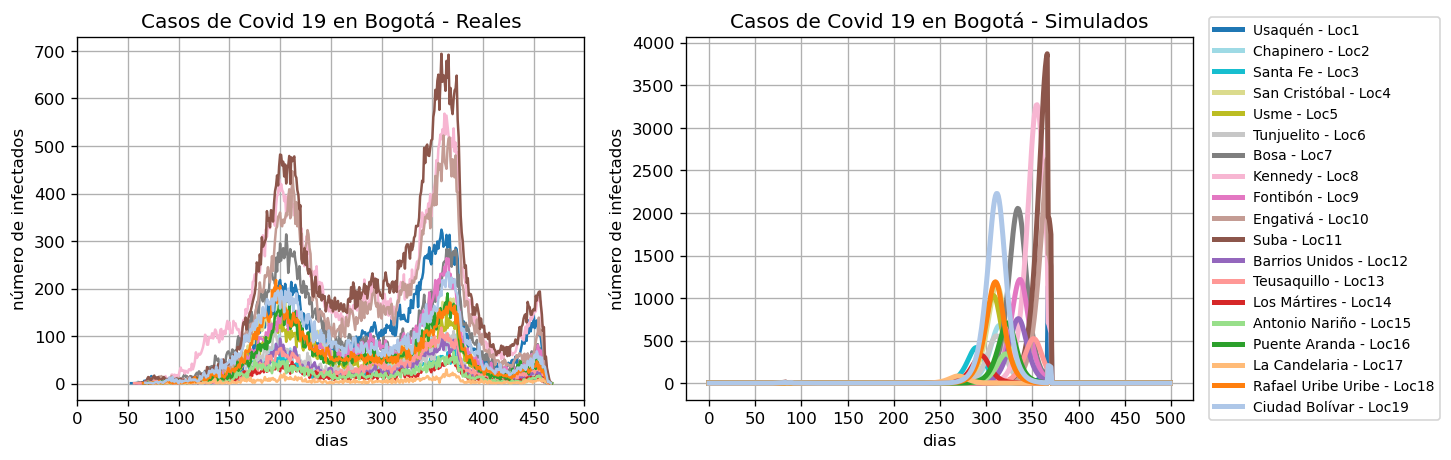

In [15]:
beta, symprob = [4.16419183, 0.13688945]
write_config(beta, symprob)
configs = sim.read_config('files1/cfg.txt')
casos_sim = sim.run_disease_simulation(configs, write_epi=True, return_epi=True)
# Grafica:
[ax1, ax2] = graficar(casos_reales, casos_sim, symprob)

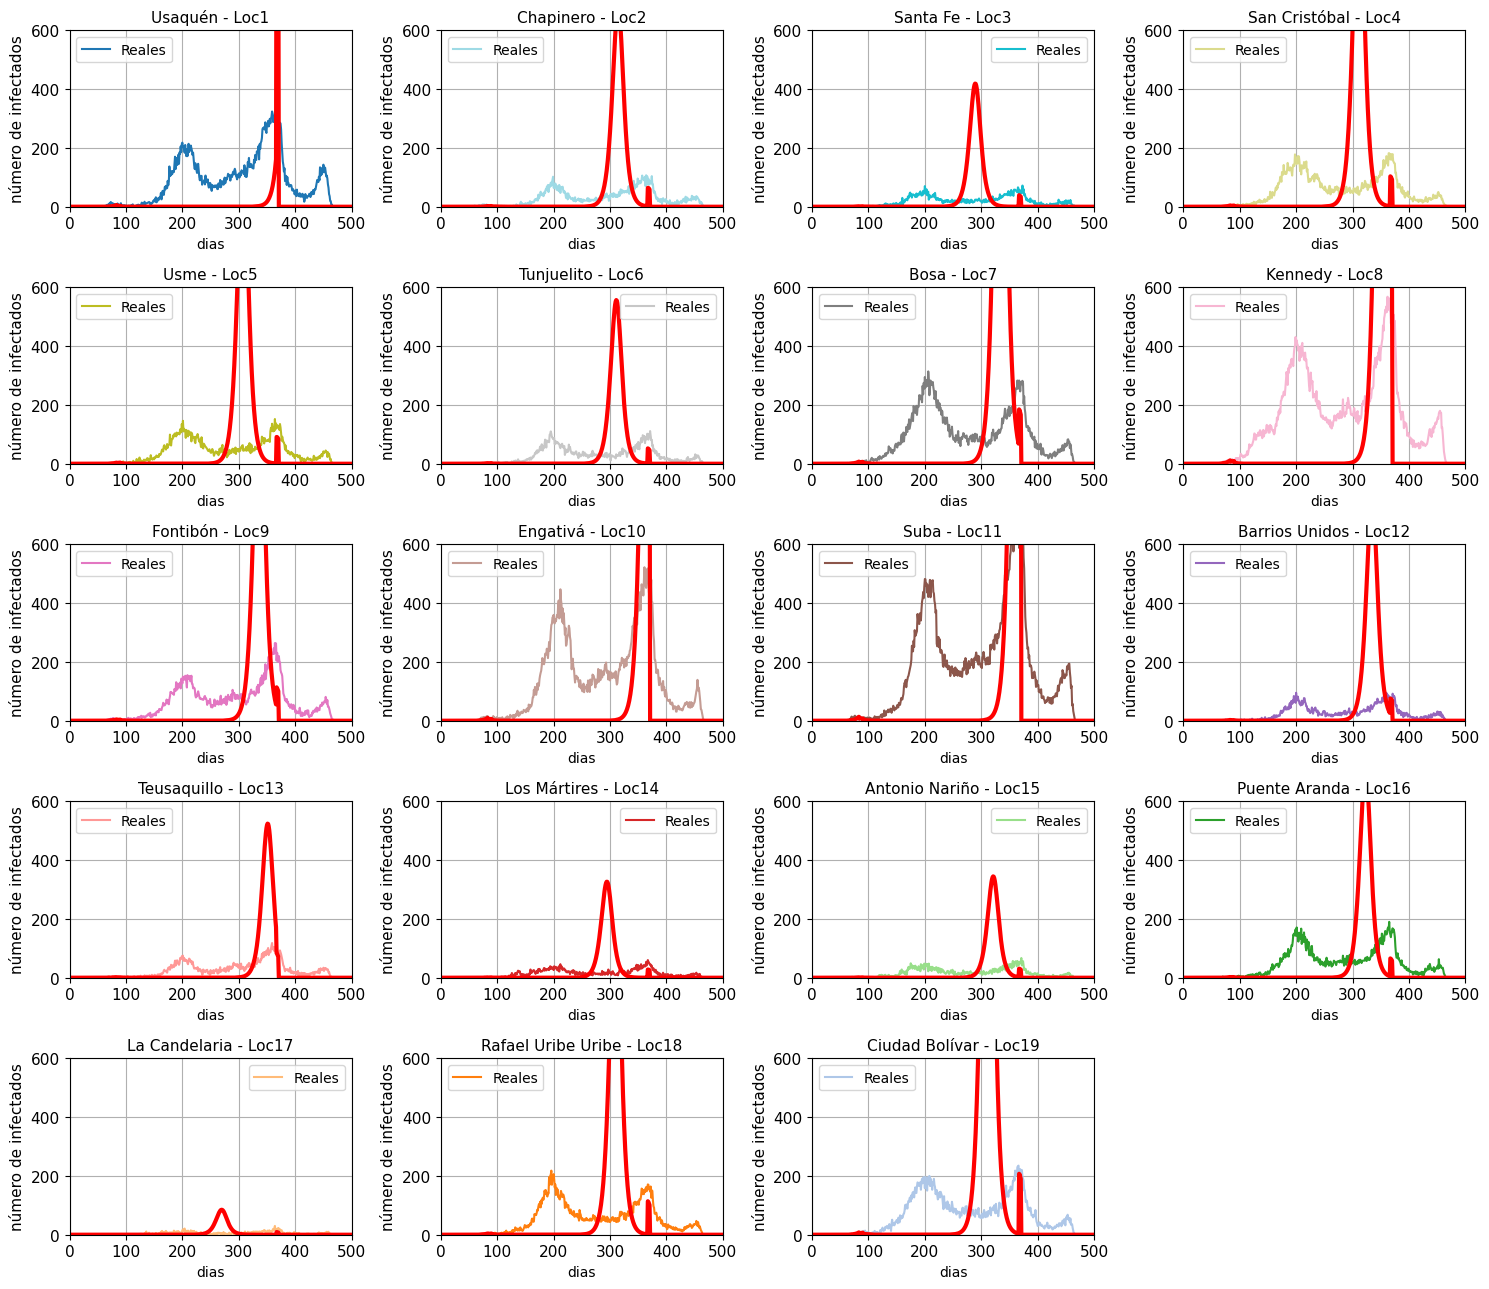

In [16]:
ax = graficar(casos_reales, casos_sim, symprob, individual=True)

   ### OPTIMIZACION

In [11]:
def simular(x, grad):
    # Escribiendo archivo cfg.txt
    beta, symprob = x[0], x[1]
    write_config(beta, symprob)
    
    # Corriendo simulacion
    configs = sim.read_config('files1/cfg.txt')
    casos_sim = sim.run_disease_simulation(configs, write_epi=True, return_epi=True)

    # DataFrame de Infectados reales y simulados
    x, y = np.meshgrid(casos_sim.columns, casos_sim.index)
    inf = pd.DataFrame(
        np.transpose([x.ravel(),y.ravel(),casos_sim.values.ravel()]), 
        columns=["dia", "local_id", "n_casos_sim"], dtype=int)
    Inf = pd.merge(inf, casos_reales, on=['dia','local_id'],  how='right')
    
    # Error   
    Inf_rango = Inf[(Inf["dia"]>=60)&(Inf["dia"]<=260)]
    Error = (Inf_rango["n_casos_real"] - symprob*Inf_rango["n_casos_sim"])**2
    Error = np.sum(Error)/len(Error)/19
    return Error

In [14]:
# Optimizacion:
def Optimizar(b0, sp0):
    n = 2 # Numero de variables a optimizar : Beta y SymProb
    Nitr = 1000 # Numero maximo de iteraciones 

    inf = [0.5, 0.05] # Limites inferiores
    sup = [5, 1]  # Limites superiores

    opt = nlopt.opt(nlopt.LN_NELDERMEAD, n)
    opt.set_lower_bounds(inf)
    opt.set_upper_bounds(sup)
    opt.set_maxeval(Nitr)
    opt.set_min_objective(simular)
    opt.set_xtol_rel(1e-5)
    x0 = np.array([b0, sp0])
    x = opt.optimize(x0)
    return x

x_opt = Optimizar(2, 0.1)
e = simular(x_opt, 0)
print(x_opt, e)

[4.16419183 0.13688945] 541.2701787091889
